In [1]:
# Importing the requisite packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal
import splot
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
from IPython.display import display, Markdown, display_latex, display_markdown, display_html

## 1. Preparing the Data

In [2]:
### Reading in the data
data_path = r'YOUR FILE PATH'

# REMINDER - The listings data must be downloaded from Inside Airbnb
listings = pd.read_csv(data_path + 'NY Airbnb June 2020\listings.csv.gz', compression='gzip', low_memory=False)

# Subsetting the data
listings_sub = listings[['id','property_type','neighbourhood_cleansed', 'neighbourhood_group_cleansed',
                         'beds','bathrooms','accommodates','bedrooms',
                         'price','latitude','longitude']]

# Cleaning the data
listings_sub.drop(columns=['beds','bathrooms'], inplace=True)
listings_sub["price"] = listings_sub["price"].replace("[$,]", "", regex=True).astype(float)
listings_sub["bedrooms"] = listings_sub["bedrooms"].fillna(value=0)

# Convert the pandas dataframe to a geopandas dataframe
listings_sub_gpd = gpd.GeoDataFrame(listings_sub, geometry=gpd.points_from_xy(listings_sub.longitude, listings_sub.latitude, crs=4326))

# Reading in the New York Census Tracts
NY_tracts_path = "https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_36_tract.zip"
NY_Tracts = gpd.read_file(NY_tracts_path)
NY_Tracts = NY_Tracts.to_crs(4326)

# Subsetting the census tracts to those in the New York CBSA
cbsa_path = 'https://www2.census.gov/geo/tiger/TIGER2021/CBSA/tl_2021_us_cbsa.zip'
cbsas = gpd.read_file(cbsa_path)
NY_cbsa = cbsas[cbsas['GEOID']=='35620']

mask = NY_Tracts.intersects(NY_cbsa.loc[620,'geometry'])
NY_Tracts_subset = NY_Tracts.loc[mask]

# Aggregating the airbnb locations to the NY census tracts
NY_Tracts_sj = gpd.sjoin(NY_Tracts_subset, listings_sub_gpd, how='left', op='contains')
NY_Tracts_sj = NY_Tracts_sj[['GEOID','price','accommodates','bedrooms','geometry']]
NY_Tracts_Agg = NY_Tracts_sj.dissolve(by='GEOID', aggfunc='mean')

NY_Tracts_Agg.head()

import statistics

# Calculating the mean and standard deviation
mean_price = statistics.mean(NY_Tracts_Agg['price'].dropna())
stdev = statistics.stdev(NY_Tracts_Agg['price'].dropna())

# Droping records that are more than 1 standard deviation from the mean
NY_Tracts_Agg_filtered = NY_Tracts_Agg[NY_Tracts_Agg['price'] < mean_price+stdev]
NY_Tracts_Agg_filtered.reset_index(inplace=True)
NY_Tracts_Agg_filtered.head()

## 2. Spatial Hypothesis Testing

In [4]:
# Importing Packages
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

C:\Users\imdav\Anaconda3\envs\GeospatialPython\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


### 2.1 Global Spatial Autocorrelation

#### 2.1.1 Moran's I

In [5]:
# Generate W from the GeoDataFrame
# Need to convert this to polygon data
w = weights.Queen.from_dataframe(NY_Tracts_Agg_filtered)

# Row-standardization
w.transform = 'R'

('WARNING: ', 1141, ' is an island (no neighbors)')
('WARNING: ', 1947, ' is an island (no neighbors)')


In [6]:
# Calculate the spatial lag
NY_Tracts_Agg_filtered['price_lag'] = weights.spatial_lag.lag_spatial(
    w, NY_Tracts_Agg_filtered['price']
)

# Standardize the variable of interest and the lag variable
NY_Tracts_Agg_filtered['price_std'] = (NY_Tracts_Agg_filtered['price'] - NY_Tracts_Agg_filtered['price'].mean())
NY_Tracts_Agg_filtered['price_lag_std'] = (NY_Tracts_Agg_filtered['price_lag'] - NY_Tracts_Agg_filtered['price_lag'].mean())

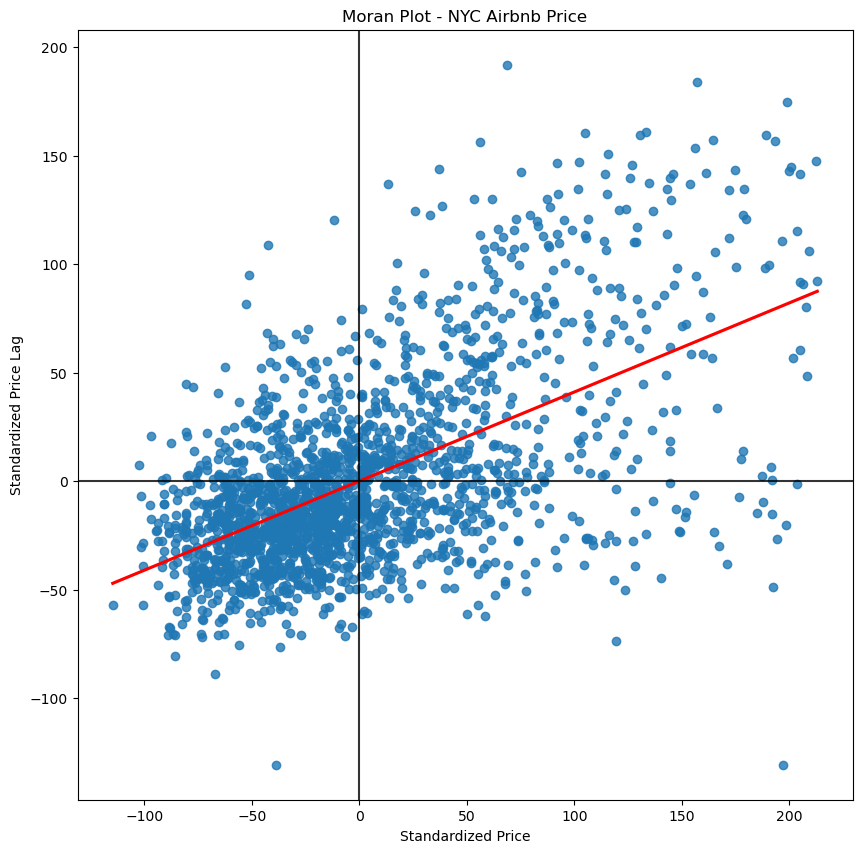

In [7]:
f, ax = plt.subplots(1, figsize=(10, 10))
seaborn.regplot(
    x='price_std', # variable of interest
    y='price_lag_std', # spatial lag
    ci=None, # suppress the plotting of the confidence interval
    data=NY_Tracts_Agg_filtered, # dataset
    line_kws={'color':'r'}
)

ax.axvline(0, c='k', alpha=0.8)
ax.axhline(0, c='k', alpha=0.8)

ax.set_title('Moran Plot - NYC Airbnb Price')
ax.set_xlabel('Standardized Price')
ax.set_ylabel('Standardized Price Lag')
plt.show()

In [8]:
morans_stat = esda.moran.Moran(NY_Tracts_Agg_filtered['price'], w)
display(Markdown(f"""**Morans I:** {morans_stat.I}"""))
display(Markdown(f"""**p-value:** {morans_stat.p_sim}"""))

**Morans I:** 0.4140183937490883

**p-value:** 0.001

(<Figure size 1000x400 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.41', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.41)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

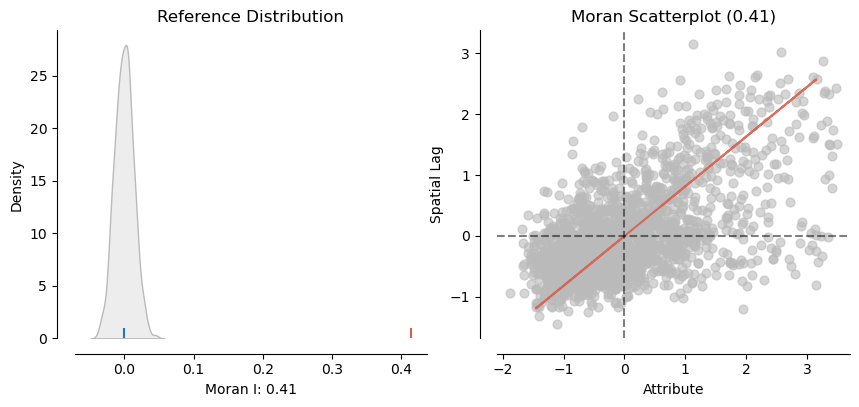

In [9]:
plot_moran(morans_stat)

**Morans I for accommodates:** 0.11319932036298101

**p-value for accommodates:** 0.001

**Morans I for bedrooms:** 0.10262754083216395

**p-value for bedrooms:** 0.001

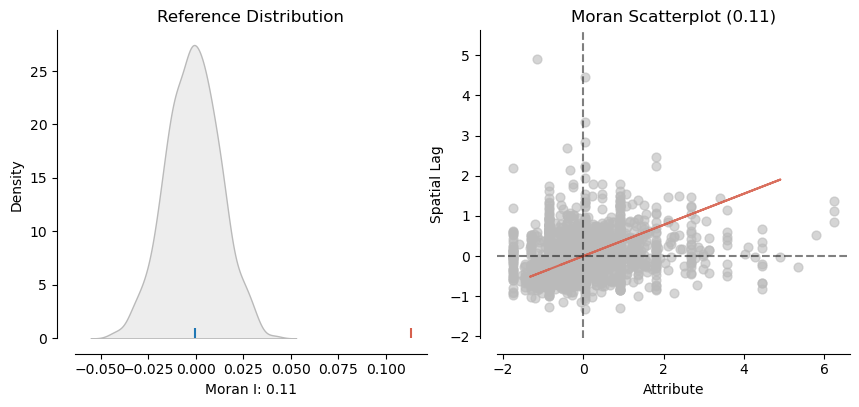

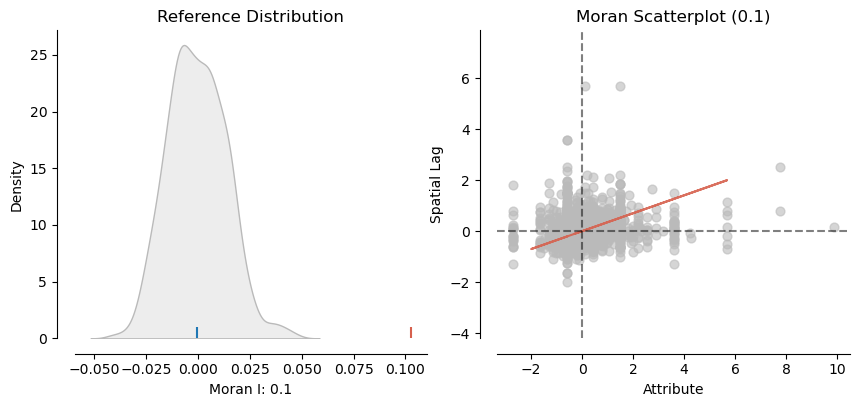

In [10]:
import numpy as np
from esda.moran import Moran

# Set seed for reproducibility
np.random.seed(54321)

# Set the variables of interest
variables_of_interest = ['accommodates','bedrooms']

for voi in variables_of_interest:
    morans_stat = esda.moran.Moran(NY_Tracts_Agg_filtered[voi], w)
    display(Markdown(f"""**Morans I for {voi}:** {morans_stat.I}"""))
    display(Markdown(f"""**p-value for {voi}:** {morans_stat.p_sim}"""))
    plot_moran(morans_stat)


#### 2.1.2 Geary's C

In [11]:
# Set the variables of interest
variables_of_interest = ['price','accommodates','bedrooms']

for voi in variables_of_interest:
    geary_c = esda.geary.Geary(NY_Tracts_Agg_filtered[voi], w)
    display(Markdown(f"""**Geary's C for {voi}:** {geary_c.C}"""))
    display(Markdown(f"""**p-value for {voi}:** {geary_c.p_sim}"""))

**Geary's C for price:** 0.5752241719341424

**p-value for price:** 0.001

**Geary's C for accommodates:** 0.8726235585071773

**p-value for accommodates:** 0.001

**Geary's C for bedrooms:** 0.8857747630853288

**p-value for bedrooms:** 0.001

### 2.2 Local Spatial Autocorrelation

In [12]:
price_lisa = esda.moran.Moran_Local(NY_Tracts_Agg_filtered['price'], w)

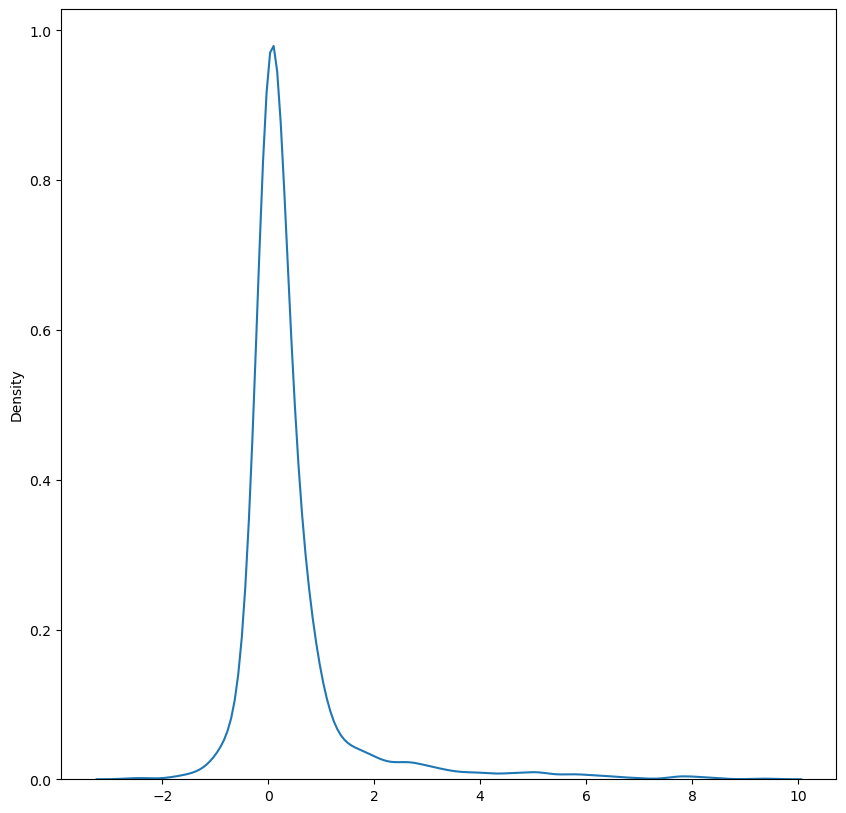

In [13]:
# Draw KDE line
f, ax = plt.subplots(1, figsize=(10, 10))
seaborn.kdeplot(price_lisa.Is, ax=ax)

plt.show()

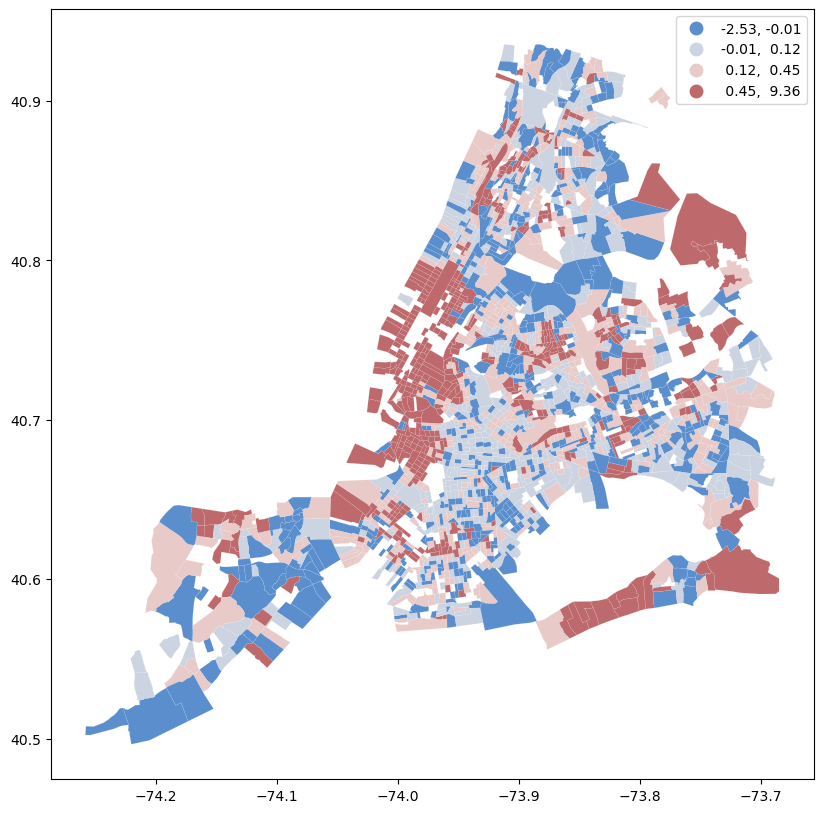

In [14]:
f, ax = plt.subplots(1, figsize=(10, 10))

# Create a new column with the values from the Moran's Local LISAs
NY_Tracts_Agg_filtered.assign(
    ML_Is=price_lisa.Is
    
# Plot choropleth of local statistics
).plot(
    column='ML_Is', 
    cmap='vlag', 
    scheme='quantiles',
    k=4, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

plt.show()

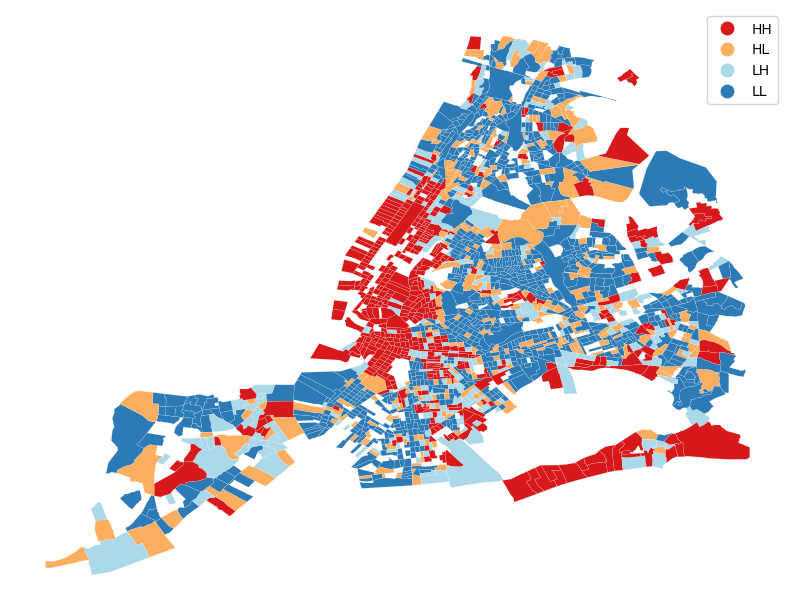

In [15]:
# import additional package esda from splot
from splot import esda as esdaplot

# Plot a map assigning each observation with its quadrant value HH, HL, LH, LL
f, ax = plt.subplots(1, figsize=(10, 10))
esdaplot.lisa_cluster(price_lisa, NY_Tracts_Agg_filtered, p=1, ax=ax);

plt.show()

<AxesSubplot:>

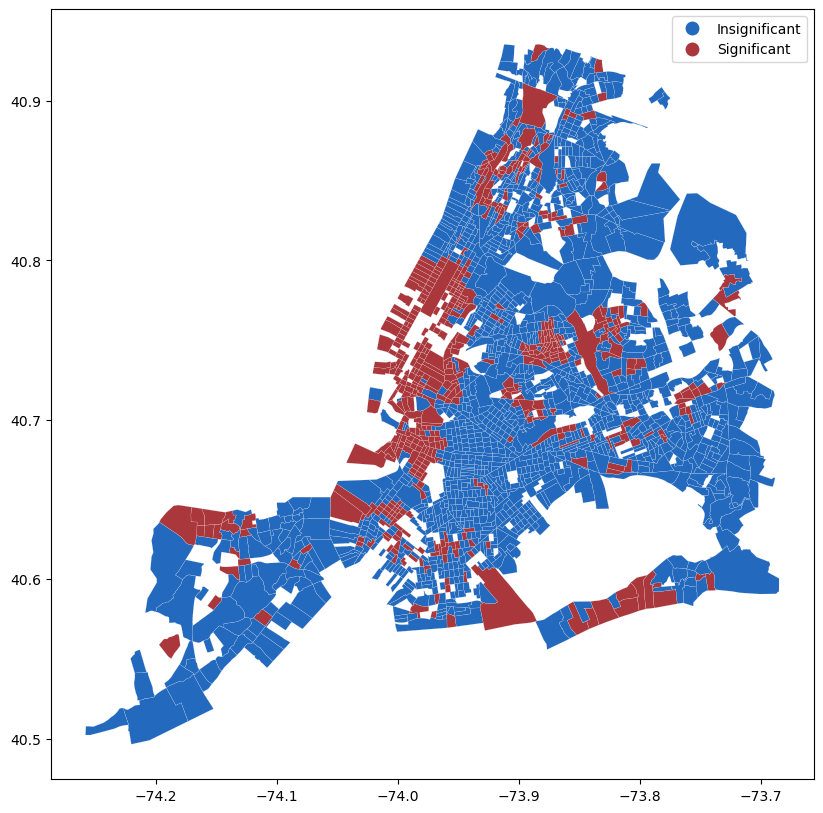

In [16]:
f, ax = plt.subplots(1, figsize=(10, 10))

# First, we need to find out which observations are significant
alpha = 0.05
labels = pd.Series(
    1 * (price_lisa.p_sim < alpha), # 1: Indicates significance at alpha of .05 and 0 indicates insignificant values
    index=NY_Tracts_Agg_filtered.index

# Recoding 1 to be "Significant and 0 to be "Insignificant"
).map({1: 'Significant', 0: 'Insignificant'})

# Creating a new column with the labels for significance called ML_Sig
NY_Tracts_Agg_filtered.assign(
    ML_Sig=labels

# Ploting a map of the insignificant values
).plot(
    column='ML_Sig', 
    categorical=True,
    k=2,
    cmap='vlag',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

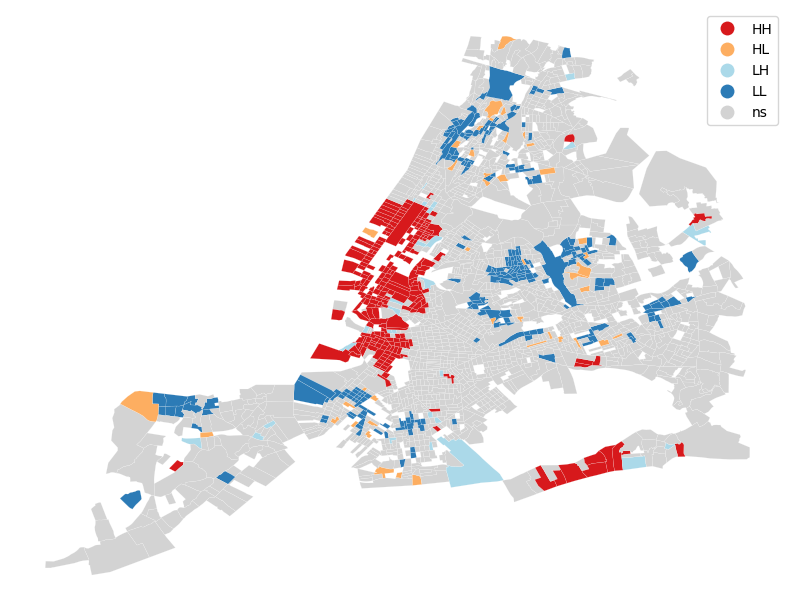

In [17]:
# Plot one final map using the alpha of 0.05
f, ax = plt.subplots(1, figsize=(10, 10))

esdaplot.lisa_cluster(price_lisa, NY_Tracts_Agg_filtered, p=alpha, ax=ax);

plt.show()